In [99]:
from IPython.display import Image
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [110]:
workers = 2 # Количество воркеров для сборки датасета
image_size = 64 # Размер входа сети для изображений. Все изображения ресайзятся к нему
nc = 3 # Количество каналов цвета
ngf = 64 # Size of feature maps in generator
ndf = 64 # Рамер карты признаков для генератора
beta1 = 0.5 # Параметр для оптимизатора Adam
ngpu = 0 # Количество GPU, 0 если считаем на CPU
nz = 100 # Размер латентного вектора (размерность латентного пространства)

In [101]:
# Для создания датасета используем класс ImageFolder
dataset = dset.ImageFolder(root='./dcgan/img_align_celeba',
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

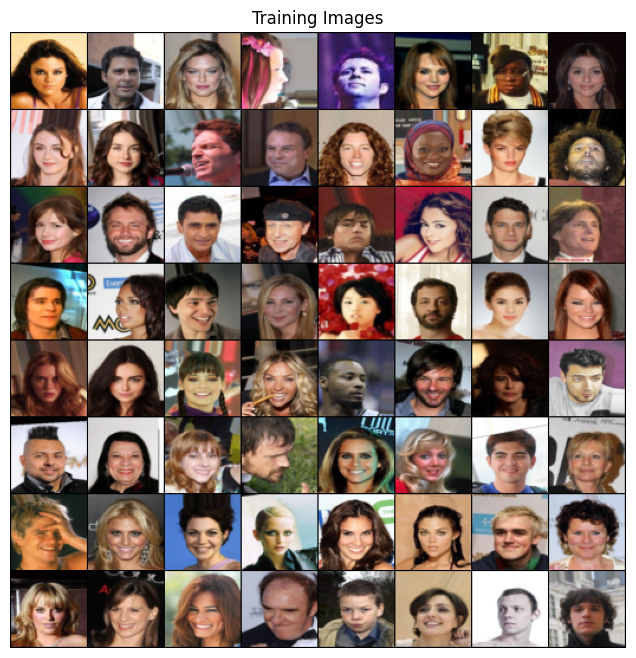

In [134]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=workers,
                                         shuffle=True,
                                        #  sampler=torch.utils.data.SubsetRandomSampler(range(int(len(dataset) * 0.3)))
)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Нарисуем часть картинок из датасета
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))

In [111]:
# Имплементация генератора
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # вход Z, идет в convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [112]:
# Имплементация дискриминатора
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [133]:
# кастомная инициализация весов netG или netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# nz = 100 # Размер латентного вектора (размерность латентного пространства)
# Инициализируем генератор
netG = Generator(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
# Инициализируем веса
netG.apply(weights_init)
#print(netG)

# инициализируем дискриминатор
netD = Discriminator(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
# Инициализируем веса
netD.apply(weights_init)
#print(netD)

# Инициализируем лосс
criterion = nn.BCELoss()
# Создаем батч с рандомным шумом для генерации
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
# Метки для реальных данных и фековых
real_label = 1.
fake_label = 0.
# Устанавливаем оптимизаторы для G и D
lr = 0.001 # Лернингрейт
#optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.SGD(netD.parameters(), lr=0.005) #Use SGD for discriminator and ADAM for generator
# optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.3, 0.8))

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 2
print("Starting Training Loop...")
for epoch in range(num_epochs):
    # Для каждого батча
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Учим дискриминатор: максимизируем log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Для батча
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Прямой прогон батча из реальных картинок D
        output = netD(real_cpu).view(-1)
        # Считаем лосс на всем батче реальных картинок
        errD_real = criterion(output, label)
        # Вычисляем градиенты для дискриминатора
        errD_real.backward()
        D_x = output.mean().item()
        ## Учим на полном фейковом батче
        # Генерируем бат латентных векторов
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Генерируем фековый батч с помощью G
        fake = netG(noise)
        label.fill_(fake_label)
        # Классифицируем фековый батч с помощью D
        output = netD(fake.detach()).view(-1)
        # Вычисляем лосс дискриминатора на фейковом батче
        errD_fake = criterion(output, label)
        # Вычисляем градиент для фейкового батча, он суммируется с предидущим
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Вычисляем ошибку на реальном и фековом батчах
        errD = errD_real + errD_fake
        # Обновляем веса D
        optimizerD.step()
        ############################
        # (2) Учим генератор: максимизируем log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # для генератора фейковые метки есть реальные (0 меняем на 1)
        # Так как мы обновили веса дискриминатора прогоним фековый батч через него еще  раз
        output = netD(fake).view(-1)
        # Вычислим лосс G основываясь на выходе D
        errG = criterion(output, label)
        # Вычислим градиент для G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Обновляем веса G
        optimizerG.step()

        # Выводим статистику обучения
        if i % 5 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Сохраним лоссы
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Проверим какие картинки рисует генератор
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=1, normalize=True))

        iters += 1

Starting Training Loop...
[0/2][0/118]	Loss_D: 1.7389	Loss_G: 6.4758	D(x): 0.6242	D(G(z)): 0.6274 / 0.0029


KeyboardInterrupt: 

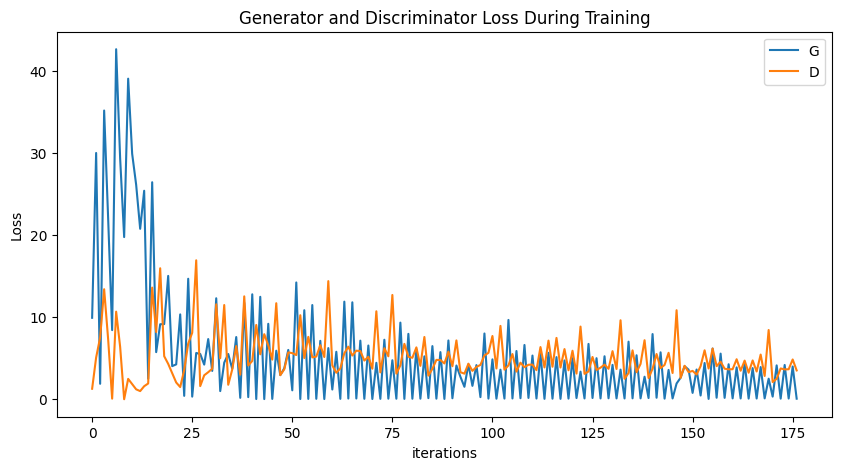

In [128]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

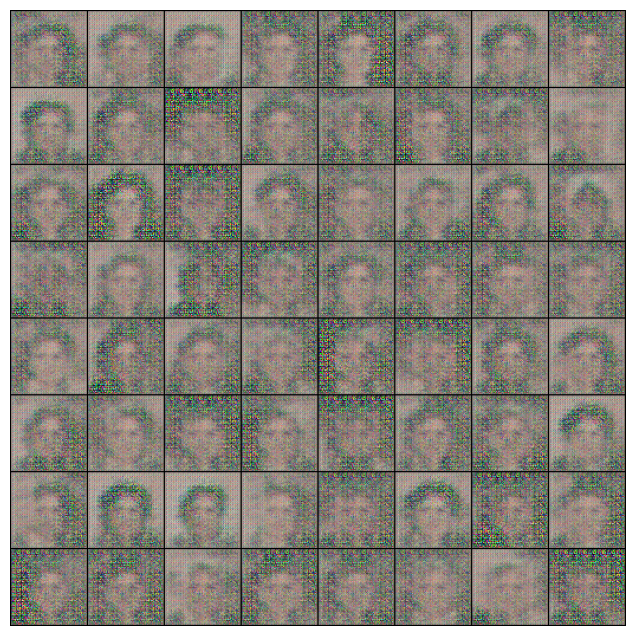

In [129]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())